# 概要
学習済みLSTMモデルの評価を行う。
* モデルを使った英→日の翻訳を行う
* 与えられた文章のBLEUスコアの平均値を算出する

# 前提パッケージのインストール
モデルの可視化のため、pydotをインストールする

In [1]:
!pip install --user pydot

You should consider upgrading via the 'pip install --upgrade pip' command.


終了後一度kernel restartする

# モジュール、モデルのロード

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15554071161273717340, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6507052368661346304
 physical_device_desc: "device: XLA_CPU device"]

In [2]:
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
import numpy as np

Using TensorFlow backend.


In [3]:
filepath = 'saved_models/LSTM/20epochs_LSTM.h5'
model = keras.models.load_model(filepath)












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




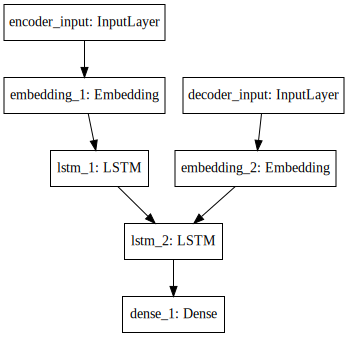

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 18)           0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, 17)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 18, 256)      1699328     encoder_input[0][0]              
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 17, 256)      2247168     decoder_input[0][0]              
__________________________________________________________________________________________________
lstm_1 (LS

モデルはLSTMを使ったseq2seqモデル。

入力を256次元にEmbeddingし、LSTMによってhidden states(h,c)にエンコーディングする。

エンコードされたhidden states(h,c)をデコーダーのLSTMに渡し、LSTM出力をDense+softmaxで単語ごとの確率に変換する。

# 推論モデルの構築
seq2seq学習時はt番目の正解単語を使ってt+1番目の単語を予測させていた(teacher forcing)。

推論時はt番目の出力単語を使ってt+1番目の単語を予測する必要があるので、データの流れが異なる。

このノートでは、学習時に得た重みを使った別のモデルを定義することでこの流れを実現している。

## 推論用encoderの定義
encoderは学習時も推論時も同様の振る舞いをするため、学習時のモデルがそのまま流用できる。

In [6]:
#define encoder
encoder_model = Model(inputs=model.input[0], #encoder_input
                      outputs=model.get_layer('lstm_1').output[1:]) #enconder lstm hidden state

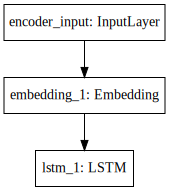

In [7]:
SVG(model_to_dot(encoder_model).create(prog='dot', format='svg'))

## 推論用decoderの定義
decoderはteacher forcingをしないので定義を変更する必要がある。

大まかに、以下の流れで処理を行う。
1. 入力された1単語をembedding_dim次元にembedding
2. さらに入力としてunits次元の2つのベクトルdecoder_state_input_h, decoder_state_input_cを受け取る
3. embedding, decoder_state_input_h, decoder_state_input_cをLSTMに入力する
4. LSTMのoutputをDense+softmaxで出力単語ごとの確率に変換する
5. モデルのアウトプットに出力単語ごとの確率、LSTMのstate_h, state_cを設定

embedding, LSTM, Denseにはそれぞれ学習済みの重みを利用する

In [8]:
#define decoder
embedding_dim = 256
units = 1024
vocab_tar_size = model.get_layer('dense_1').weights[1].shape.as_list()[0]

decoder_word_input = Input(shape=(1,),name='decoder_input')
decoder_input_embedding = Embedding(input_dim=vocab_tar_size, 
                                    output_dim=embedding_dim,
                                    weights=model.get_layer('embedding_2').get_weights())(decoder_word_input)


decoder_state_input_h = Input(shape=(units,), name='decoder_input_h')
decoder_state_input_c = Input(shape=(units,), name='decoder_input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm = LSTM(units, 
                    return_sequences=False, 
                    return_state=True,
                    weights=model.get_layer('lstm_2').get_weights())
decoder_output, state_h, state_c = decoder_lstm(decoder_input_embedding,
                                                initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]

decoder_dense = Dense(vocab_tar_size, 
                      activation='softmax',
                      weights=model.get_layer('dense_1').get_weights())
decoder_output = decoder_dense(decoder_output)

decoder_model = Model(inputs=[decoder_word_input] + decoder_states_inputs,
                      outputs=[decoder_output] + decoder_states)

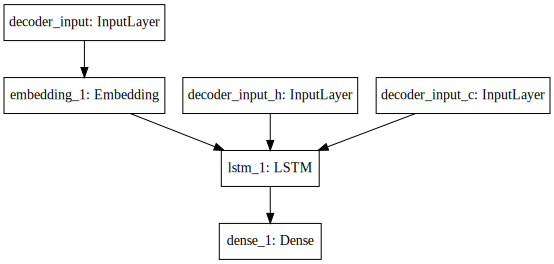

In [9]:
SVG(model_to_dot(decoder_model).create(prog='dot', format='svg'))

In [10]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 256)       2247168     decoder_input[0][0]              
__________________________________________________________________________________________________
decoder_input_h (InputLayer)    (None, 1024)         0                                            
__________________________________________________________________________________________________
decoder_input_c (InputLayer)    (None, 1024)         0                                            
__________________________________________________________________________________________________
lstm_1 (LS

# 評価用コーパスの用意
trainingと同じ処理でコーパスを前処理する。ただしtrainでTokenizerを作り、testの文章を読み込む。

In [11]:
# ユニコードファイルを ascii に変換
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = w.rstrip().strip()

    # 文の開始と終了のトークンを付加
    # モデルが予測をいつ開始し、いつ終了すれば良いかを知らせるため
    w = '<start> ' + w + ' <end>'
    return w

In [12]:
def create_dataset(path, num_examples):
    with open(path) as f:
        word_pairs = f.readlines()
    word_pairs = [preprocess_sentence(sentence) for sentence in word_pairs]

    return word_pairs[:num_examples]

In [13]:
# データの読み込み
path_train_en = 'small_parallel_enja/train.en'
path_train_ja = 'small_parallel_enja/train.ja'
en = create_dataset(path_train_en, None)
ja = create_dataset(path_train_ja, None)
print(en[-1])
print(ja[-1])

<start> he thought irritably . <end>
<start> 彼 は いらだ ち ながら 思 っ た 。 <end>


In [14]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [15]:
def tokenize(lang):
    #これはなくす。
    #学習済みw2vをembeddingにつかうので
    lang_tokenizer = keras.preprocessing.text.Tokenizer(filters='', oov_token='<unk>')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [16]:
def load_dataset(path, num_examples=None):
    # クリーニングされた入力と出力のペアを生成
    lang = create_dataset(path, num_examples)

    tensor, lang_tokenizer = tokenize(lang)

    return tensor, lang_tokenizer

In [17]:
# 単語へのIDの割り振りとID列への変換
# このサイズのデータセットで実験
num_examples = None
input_tensor, inp_lang = load_dataset(path_train_en, num_examples)
target_tensor, targ_lang = load_dataset(path_train_ja, num_examples)
# ターゲットテンソルの最大長を計算
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [18]:
max_length_targ

18

In [20]:
# testデータの読み込み
path_test_en = 'small_parallel_enja/test.en'
path_test_ja = 'small_parallel_enja/test.ja'
en_test = create_dataset(path_test_en, None)
ja_test = create_dataset(path_test_ja, None)
print(en_test[-1])
print(ja_test[-1])

<start> where do you come from ? <end>
<start> どこ の ご 出身 で す か 。 <end>


In [21]:
test_inp_tensor = inp_lang.texts_to_sequences(en_test)
test_inp_tensor = keras.preprocessing.sequence.pad_sequences(test_inp_tensor, padding='post')

test_targ_tensor = targ_lang.texts_to_sequences(ja_test)
test_targ_tensor = keras.preprocessing.sequence.pad_sequences(test_targ_tensor, padding='post')

In [22]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [23]:
print ("Input Language; index to word mapping")
convert(inp_lang, test_inp_tensor[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, test_targ_tensor[0])

Input Language; index to word mapping
2 ----> <start>
54 ----> they
780 ----> finally
2450 ----> acknowledged
14 ----> it
39 ----> as
201 ----> true
4 ----> .
3 ----> <end>

Target Language; index to word mapping
2 ----> <start>
15 ----> 彼
33 ----> ら
5 ----> は
1113 ----> つい
7 ----> に
49 ----> それ
14 ----> が
518 ----> 真実
23 ----> だ
25 ----> と
861 ----> 認め
8 ----> た
4 ----> 。
3 ----> <end>


# 翻訳を行う関数の定義
構築した推論モデルを使って実際に翻訳を行う関数を定義する。処理の流れの概要は以下
1. encoderで入力文章をhidden statesに変換
2. 文章開始トークンのword_indexとhidden statesをdecoderに入力し、2番目の単語のword_indexと更新されたhidden statesを得る
3. 得られたword_indexをdecoded_sentenceに記録する
4. max_length_targに達するまでword_indexとhidden statesをdecoderに入力し、decoded_sentenceを得る
5. decoded_sentenceに記録されたword_indexを単語に変換する

In [24]:
def decode_sequence(input_seq, targ_lang, max_length_targ):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    vocab_tar_size = np.array(list(targ_lang.index_word.keys())).max()
    inp_batch_size = len(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((inp_batch_size, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[:, 0] = targ_lang.word_index['<start>']
    
    # Sampling loop for a batch of sequences
    decoded_sentence = np.zeros((inp_batch_size, max_length_targ))
    
    for i in range(max_length_targ):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens,axis=1) #array of size [inp_batch_size, 1]

        decoded_sentence[:,i] = sampled_token_index

        # Update the target sequence (of length 1).
        target_seq = np.zeros((inp_batch_size, 1))
        target_seq[:, 0] = sampled_token_index

        # Update states
        states_value = [h, c]


    return decoded_sentence    

decode_sequence(test_inp_tensor[0:5],targ_lang,max_length_targ)

array([[  15.,   33.,    5.,   27.,  121.,    9.,  482.,    6.,    8.,
           4.,    3.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [  15.,    5.,  392.,  570.,    7.,    5., 1307.,   16.,   13.,
          43.,    8.,    4.,    3.,    0.,    0.,    0.,    0.,    0.],
       [  15.,    5.,   40.,  465.,  126.,    7., 1070.,   33.,  218.,
         411.,   14.,    6.,    6.,    4.,    3.,    0.,    0.,    0.],
       [ 188.,   71.,   79.,    7.,    5.,  174.,   33.,   13.,  110.,
          53.,   13.,   33.,   13.,    6.,    4.,    3.,    0.,    0.],
       [ 785.,    9.,  800.,    6.,   13.,   52.,    6.,    4.,    3.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])

In [25]:
#decoded_sentenseのword_indexを単語に変換し、開始・終了トークンを取り除く
def seq2sentence(seq,lang):
    def index2lang(idx, lang):
        try:
            return lang.index_word[idx]
        except KeyError:
            return ''
    langseq2sentence = np.vectorize(lambda x: index2lang(x,lang),otypes=[str])
    sentences = langseq2sentence(seq)
    sentences = [' '.join(list(sentence)) for sentence in sentences]
    sentences = [sentence.lstrip('<start>').strip(' ').strip('<end>') for sentence in sentences]
    return sentences

In [26]:
val_input = seq2sentence(test_inp_tensor[0:5],inp_lang)
val_input

['they finally acknowledged it as true . ',
 "he didn 't care for swimming . ",
 'he is no less kind than his sister . ',
 'you must be back before ten . ',
 'break a leg . ']

In [27]:
prediction = seq2sentence(decode_sequence(test_inp_tensor[0:5],targ_lang,max_length_targ),targ_lang)
prediction

['彼 ら は その 問題 を 解 い た 。 ',
 '彼 は 泳 ぐ に は 想像 し な かっ た 。 ',
 '彼 は お 姉 さん に 劣 ら ず 頭 が い い 。 ',
 '１０ 時 まで に は 帰 ら な けれ ば な ら な い 。 ',
 '足 を 洗 い な さ い 。 ']

In [29]:
val = seq2sentence(test_targ_tensor[0:5],targ_lang)
val

['彼 ら は つい に それ が 真実 だ と 認め た 。 ',
 '彼 は 水泳 が 得意 で は な かっ た 。 ',
 '彼 は お 姉 さん に 劣 ら ず 親切 だ 。 ',
 '１０ 時 前 に 戻 ら な けれ ば な ら な い 。 ',
 '成功 を 祈 る わ 。 ']

# BLEUスコア算出

In [30]:
# BLUE score
from nltk.translate.bleu_score import sentence_bleu
def calc_BLEU(pred_l,test_l):
    score = [sentence_bleu([reference], candidate) for reference, candidate in zip(test_l,pred_l)]
    return np.mean(score)

In [41]:
def cal_corpus_BLEU(test_inp,test_targ,batch_size):
    schedule_idx = [[i*batch_size, (i+1)*batch_size]for i in range(divmod(len(test_inp),batch_size)[0])]
    if divmod(len(test_inp),batch_size)[1] != 0:
        schedule_idx += [[divmod(len(test_inp),batch_size)[0]*batch_size,len(test_inp)]]
        
    scores = []
    for start_idx, end_idx in schedule_idx:
        prediction = seq2sentence(decode_sequence(test_inp_tensor[start_idx:end_idx],targ_lang,max_length_targ),targ_lang)
        target = seq2sentence(test_targ_tensor[start_idx:end_idx],targ_lang)
        score = calc_BLEU(prediction,target)
        scores.append(score)
    return np.mean(scores)
cal_corpus_BLEU(test_inp_tensor, test_targ_tensor,batch_size=100)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lowe

0.3807680679420746

LSTMでのBLEUは0.38